In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.LP import SpatialLocalPooling
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

In [4]:
adata=sc.read_h5ad('/home/dbj/SpaLP/Tutorialdata/CosMxMouseBrain.h5ad')
adata.var_names_make_unique()
adata.obs['truth']=adata.obs['spatialClusteringAssignments']
adata.obs['truth'] = adata.obs['truth'].astype('category')
sc.pp.normalize_total(adata,inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat'] = adata.X
adata

AnnData object with n_obs × n_vars = 48180 × 950
    obs: 'spatialClusteringAssignments', 'truth'
    var: 'mean', 'std'
    uns: 'RNA_nbclust_clusters_colors', 'spatialClusteringAssignments_colors', 'log1p'
    obsm: 'spatial', 'feat'

In [5]:
device_idx=0
def measure_resources(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        mem_usage = memory_usage((func, args, kwargs), max_usage=True) / 1024
        end_time = time.time()
        execution_time = end_time - start_time
        minutes = execution_time // 60
        seconds = execution_time % 60
        if torch.cuda.is_available():
            device = torch.device(f"cuda:{device_idx}")
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 3) 
            cached = torch.cuda.memory_reserved(device) / (1024 ** 3)
        else:
            allocated = cached = 0

        print(f"Function '{func.__name__}' executed in {minutes} minutes and {seconds:.4f} seconds.")
        print(f"Memory usage: {mem_usage:.2f} GB")
        print(f"GPU memory allocated: {allocated:.2f} GB")
        print(f"GPU memory cached: {cached:.2f} GB")

    return wrapper

In [6]:
in_channels = adata.obsm['feat'].shape[1]
model = SpatialLocalPooling(in_channels, out_channels=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
from memory_profiler import memory_usage
from scipy.io import mmread

In [8]:
@measure_resources
def run_pipeline(adata):
    graph = prepare_inputs(adata, k=10, device=device)
    
    set_seed(7)
    epochs = 200
    pbar = tqdm(range(epochs), desc="Training",ncols=200)
    for epoch in pbar:
        start_time = time.time()
        model.train()
        optimizer.zero_grad()
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        loss = criterion(reconstructed, graph.features)
        loss.backward()
        optimizer.step()
        elapsed = time.time() - start_time
        pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

    model.eval()
    with torch.no_grad():
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        embedding=embedding.cpu().numpy()
        adata.obsm['SpaLP']=embedding
        
run_pipeline(adata=adata)

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 39.16it/s, Epoch=199, Loss=0.9190]


Function 'run_pipeline' executed in 0.0 minutes and 5.2556 seconds.
Memory usage: 1.29 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 2.62 GB


In [9]:
@measure_resources
def run_leiden(adata):
    sc.pp.neighbors(adata, use_rep='SpaLP')
    sc.tl.leiden(adata, random_state=2024, resolution=0.63,key_added='SpaLP_leiden')
run_leiden(adata=adata)

Function 'run_leiden' executed in 1.0 minutes and 15.9239 seconds.
Memory usage: 1.69 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 2.62 GB


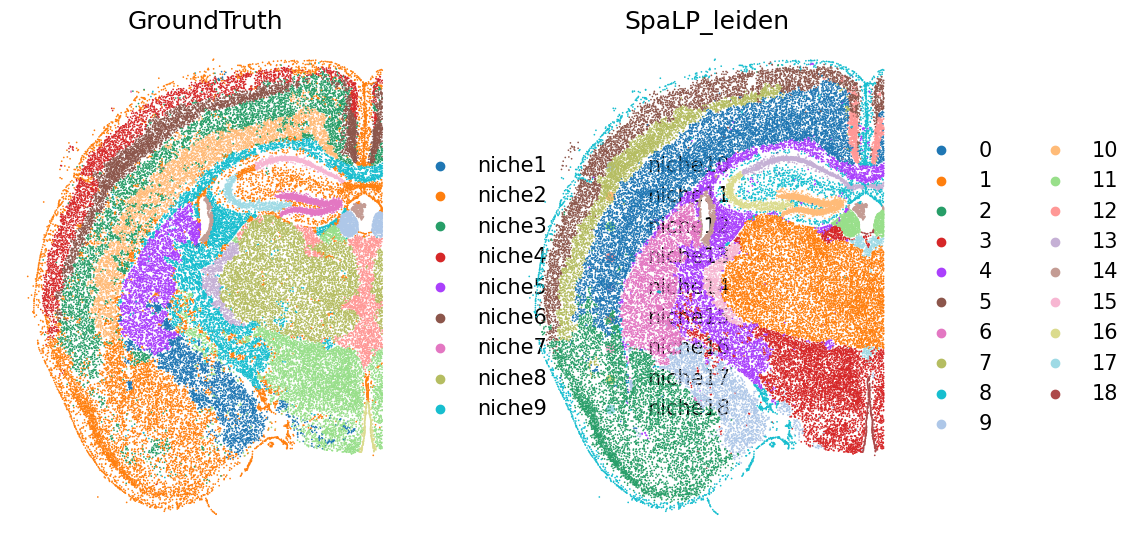

In [10]:
import matplotlib.pyplot as plt
import copy
from scanpy.plotting import palettes
plt.rcParams['figure.figsize'] = (5,6.5)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata, basis="spatial",s=6, color=['spatialClusteringAssignments','SpaLP_leiden'],colorbar_loc=None,title='GroundTruth',frameon=False,palette=palettes.default_20)

In [11]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['spatialClusteringAssignments'])
cluster_labels = np.array(adata.obs['SpaLP_leiden'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.5689880451043148
NMI: 0.7351402154527759
AMI: 0.7348087454297193
FMI: 0.6086324577105219
V-Measure: 0.7351402154527756
Homogeneity: 0.7391634106238346


In [15]:
from sklearn.cluster import KMeans
@measure_resources
def run_kmeans(adata):
    kmeans = KMeans(n_clusters=19, random_state=2024) 
    labels = kmeans.fit_predict(adata.obsm['SpaLP'])
    adata.obs['SpaLP_kmeans']=labels.astype(str)
run_kmeans(adata=adata)

Function 'run_kmeans' executed in 0.0 minutes and 0.4685 seconds.
Memory usage: 1.58 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 2.62 GB


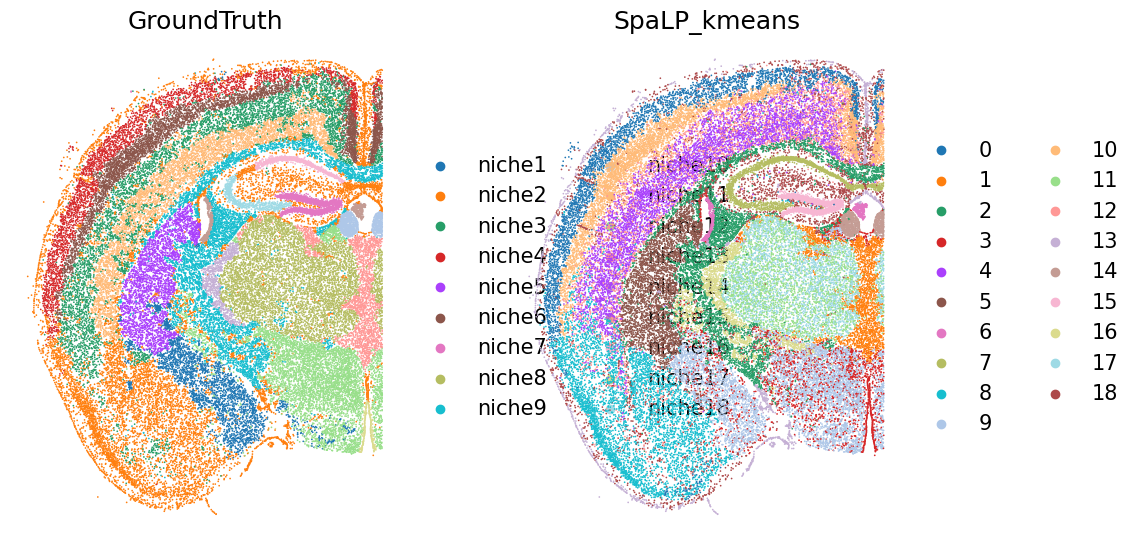

In [16]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,6.5)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata, basis="spatial",s=6, color=['spatialClusteringAssignments','SpaLP_kmeans'],colorbar_loc=None,title='GroundTruth',frameon=False,palette=palettes.default_20)

In [17]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['spatialClusteringAssignments'])
cluster_labels = np.array(adata.obs['SpaLP_kmeans'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.44764248446012617
NMI: 0.6622141690927441
AMI: 0.6618114049810594
FMI: 0.49762503231168503
V-Measure: 0.6622141690927441
Homogeneity: 0.6946300114646302


In [18]:
adata.write_h5ad('/home/dbj/STAGATE/SpaLP_CosMx_mousebrain_k_10.h5ad',compression='gzip')